# Case Study 1: Predictive Data Analytics
## Churn Prediction: “Will a customer continue their services with the bank?”

### Table of content
1. [Data Selection and Distribution](#dataprep)
2. [Predictive Modeling Using Decision Trees](#dtree)
3. [Predictive Modeling Using Regression](#regress)
4. [Predictive Modeling Using Neural Networks](#neural)
5. [Comparing Predictive Models](#compair)

In [1]:
%matplotlib inline
# Import library
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score
import pydot
from io import StringIO
from sklearn.tree import export_graphviz
import warnings
from dm_tools import analyse_feature_importance, visualize_decision_tree
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn.neural_network import MLPClassifier

# Task 1. Data Selection and Distribution<a name="dataprep"></a>


## 1.1 What is the proportion of customers who exited and stopped using the banking services?
The percentage of customers who exited and stopped using the banking services is 20.37%

In [2]:
df = pd.read_csv('churn.csv')
print(df['Exited'].value_counts(normalize=True))

No     0.7963
Yes    0.2037
Name: Exited, dtype: float64


## 1.2. The dataset may include irrelevant and redundant variables. What variables did you include in the analysis and what were their roles and measurement level set? Justify your choice. 

- `Exited` is selected as the dependent variable since the purpose of the analysis is to study if the customer has ended their engagement with the bank or not. `RowNumber`, `CustomerID`, and `Surname` are the columns that need to be dropped since they are not necessary for `sklearn` modeling algorithm to construct the model. The `Sex` column is also dropped because it contains the duplicate data as column `Gender`. We also dropped the `Geography` column because it is specific to each customer. Constructing a model on specific countries could lead to an overfitting problem. The `ComplaintsLodged` column is not included because it is a false predictor. Most customers who have lodged a complaint previously tend to stop using the bank service.

- `Age` is one of the variables that are considered to have an impact on customer churn. The elderly tend to have a more stable economy and established good relationships with their bank. Therefore, the exited rate of older people is expected to be lower. The measurement level of `Age` is the ratio scale.

- `IsActiveMember`, `CreditScore`, `HasCrCard` and `CurrentWorkingStatus` are the variables of interest. It is expected that customers who are active and own credit cards are more likely to stay using bank services. It is also believed that customers who have a steady job tend to use bank services to manage their finance. The measurement level of those variables is the nominal scale.

- `Balance`, `Tenure`, and `NumOfProducts` variables are included. The customers who have a low account balance, low credit score, short duration of active relationship with the banks, and few products are more likely to have pre-existing relations with another bank. It would increase the rate of customer churn. The measurement level of those variables is the ratio scale.

- `Gender` is the last variable of interest. In some families, there is only one member who tends to be a male who opens the bank account to facilitate financial management. The measurement level of Gender is a nominal scale.


## 1.3. Did you have to fix any data quality problems? Detail them.
- Drop unused target variables such that `RowNumber`, `CustomerId`, `Surname`, `Geography`, `Sex`, and `ComplaintsLodged`.
- Change `Exited` into binary 0/1 variable
- `Age` column contains some invalid data (Age < 1). Denote erroneous values in `Age` as NaN.
- Drop the rows that contain too much NaN data.
- Change `EstimatedSalary` into a numeric variable
- Impute missing values in `Age` with its mean
- Impute missing values in `NumOfProducts` using mean
- Impute missing values in `EstimatedSalary` with its mean
- Format `Gender` variable with one-hot encoding

In [3]:
def preprocess_data(df):
   # Drop unused target variables
   df.drop(['RowNumber', 'CustomerId', 'Surname', 'Geography', 'Sex', 'ComplaintsLodged'], axis=1, inplace=True)

   # Change Exited into binary 0/1 variable
   exited_map = {'No':0, 'Yes': 1}
   df['Exited'] = df['Exited'].map(exited_map)   

   # Denote errorneous values in Age
   mask = df['Age'] < 1
   df.loc[mask, 'Age'] = np.nan

   # Drop the rows that contain too many NaN data
   df = df.dropna(subset=['Age', 'Balance', 'Gender', 'CurrentWorkingStatus', 'Tenure','HasCrCard', 'IsActiveMember', 'CreditScore'])

   # Impute missing values in NumOfProducts using mean
   df['NumOfProducts'].fillna(round(df['NumOfProducts'].mean()), inplace=True)

   # Impute missing values in Age with its mean
   df['Age'].fillna(round(df['Age'].mean()), inplace=True)

   # Change EstimatedSalary into numeric variable
   df['EstimatedSalary'] = pd.to_numeric( df['EstimatedSalary'], errors='coerce')

   # Impute missing values in EstimatedSalary with its mean   
   df['EstimatedSalary'].fillna(df['EstimatedSalary'].mean(), inplace=True)

   # Format Gender variable with one-hot encoding
   df = pd.get_dummies(df)
   return df

## 1.4. Report the proportion of values of the target variable for the dataset after the above-mentioned pre-processing.
After pre-processing, 43 rows were removed. So, the updated distribution of the target variable is 20.3776% exited and 79.6224% remained.

In [4]:
# Ignore Warning
pd.options.mode.chained_assignment = None  # default='warn'

df = pd.read_csv('churn.csv')
df = preprocess_data(df)
df['Exited'].value_counts(normalize=True)

0    0.796224
1    0.203776
Name: Exited, dtype: float64

## 1.5. What distribution split between training and test datasets have you used?
The data is separated into 70% training dataset and 30% test data using the `.train_test_split()`.

In [5]:
rs = 10

# target/input split
y = df['Exited']
X = df.drop(['Exited'], axis=1)
X_mat = X.values
X_train, X_test, y_train, y_test = train_test_split(X_mat, y, 
                                                    test_size=0.3, 
                                                    stratify=y, 
                                                    random_state=rs)

# Task 2. Predictive Modeling Using Decision Trees<a name="dtree"></a>

## 2.1. Constructing the default decision tree

In [6]:
# simple decision tree training
model_tree_default = DecisionTreeClassifier(random_state=rs)
model_tree_default.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=10, splitter='best')

### 2.1.a What parameters have been used in building the tree? Detail them.
The input parameter used in building the default decision tree is random state, which would ensure consistent results in using the decision tree model.

Other default parameters are:

In [7]:
print(model_tree_default.get_params(True))

{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': 'deprecated', 'random_state': 10, 'splitter': 'best'}


### 2.1.c What is the size of the tree (number of nodes and rules)?
The tree has 2149 nodes and 1075 leaf nodes. So the number of rules would be 2149 - 1075 = 1074 rules.

In [8]:
print("Number of nodes: ", model_tree_default.tree_.node_count)
print("Number of leaves: ", model_tree_default.tree_.n_leaves)

Number of nodes:  2149
Number of leaves:  1075


### 2.1.b What is classification accuracy on training and test datasets?
The training accuracy of the model is 100%, while the accuracy on the test dataset is 78.58%.

In [9]:
print("Train accuracy:", model_tree_default.score(X_train, y_train))
print("Test accuracy:", model_tree_default.score(X_test, y_test))
y_pred = model_tree_default.predict(X_test)
print(classification_report(y_test, y_pred))

Train accuracy: 1.0
Test accuracy: 0.785809906291834
              precision    recall  f1-score   support

           0       0.87      0.85      0.86      2379
           1       0.48      0.52      0.50       609

    accuracy                           0.79      2988
   macro avg       0.67      0.69      0.68      2988
weighted avg       0.79      0.79      0.79      2988



### 2.1.d Which variable is used for the first split? What are the variables that are used for the second split?
Looking at the visualization of the decision tree, the variable is used for the first split is `Age`, the variables are used for the second split are `NumOfProducts` and `IsActiveMember`.

In [10]:
# visualize
visualize_decision_tree(model_tree_default, X.columns, "default_tree.png")

### 2.1.e What are the 5 important variables in building the tree? 
The 5 important variables in building the tree are `Age`, `EstimatedSalary`, `CreditScore`, `Balance`, and `NumOfProducts`.

In [11]:
# grab feature importances from the tree 
# and feature name from the original X
importances = model_tree_default.feature_importances_
feature_names = X.columns

# sort them out in descending order
indices = np.argsort(importances)
indices = np.flip(indices, axis=0)

# limit to 5 features
indices = indices[:5]

for i in indices:
    print(feature_names[i], ':', importances[i])

Age : 0.23250862966777697
EstimatedSalary : 0.16587022381215832
CreditScore : 0.1583342302974943
Balance : 0.1511189332891133
NumOfProducts : 0.11654360828180964


### 2.1.f Report if you see any evidence of model overfitting
It can be seen that the model could predict the training data with 100% accuracy. However, there is a significant difference between the prediction of the test dataset and the training dataset. It indicates that this model overfits the training data.

## 2.2 Build another decision tree tuned with GridSearchCV

In [12]:
# Building the tree with grid search CV
params = {'criterion': ['gini', 'entropy'],
          'max_depth': range(2, 7),
          'min_samples_leaf': range(20, 60, 10)}

model_tree_cv = GridSearchCV(param_grid=params, estimator= 
                  DecisionTreeClassifier(random_state=rs), cv=10)
model_tree_cv.fit(X_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=10,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'criterion': ['gini', 'entropy'],
                    

### 2.2.a What are the optimal parameters for this decision tree?
The optimal parameters for this decision tree are  {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 20}

In [13]:
# print parameters of the best model
print(model_tree_cv.best_params_)

{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 20}


### 2.2.b What is classification accuracy on training and test datasets?
The train accuracy is 85.64% and the test accuracy is 85.71%.

In [14]:
print("Train accuracy:", model_tree_cv.score(X_train, y_train))
print("Test accuracy:", model_tree_cv.score(X_test, y_test))

# test the best model
y_pred = model_tree_cv.predict(X_test)
print(classification_report(y_test, y_pred))

Train accuracy: 0.8563638972592912
Test accuracy: 0.857095046854083
              precision    recall  f1-score   support

           0       0.86      0.97      0.92      2379
           1       0.80      0.40      0.53       609

    accuracy                           0.86      2988
   macro avg       0.83      0.69      0.72      2988
weighted avg       0.85      0.86      0.84      2988



### 2.2.c What is the size of the chosen tree (number of nodes and rules)?
There are 51 nodes and 26 leaves in the decision tree tuned with `GridSearchCV`. As there are 26 leaf nodes, there would be 51-26 = 25 rules in the tree.

In [15]:
print("Number of nodes: ", model_tree_cv.best_estimator_.tree_.node_count)
print("Number of leaves: ", model_tree_cv.best_estimator_.tree_.n_leaves)

Number of nodes:  51
Number of leaves:  26


### 2.2.d Which variable is used for the first split? What are the variables that are used for the second split?
The variable used for the first split is `Age`. The variables used for the second split are `NumOfProducts` and `IsActiveMember`.

In [16]:
# do the visualization analysis on GridSearchCV's best model
visualize_decision_tree(model_tree_cv.best_estimator_, X.columns, "optimal_tree.png")

### 2.2.e What are the 5 important variables in building the tree? 
The 5 important variables in building the tree are `Age`, `NumOfProducts`, `IsActiveMember`, `Balance`, and `EstimatedSalary`.

In [17]:
analyse_feature_importance(model_tree_cv.best_estimator_, X.columns, 5)

Age : 0.45015311369024563
NumOfProducts : 0.343256206857896
IsActiveMember : 0.17103041909453676
Balance : 0.028501520577066796
EstimatedSalary : 0.006036677839659389


### 2.2.f Report if you see any evidence of model overfitting. 
Minor difference can be seen between performance on training data vs test data. It indicates that the model generalises better and is not overfitting.

## 2.3 What is the significant difference do you see between these two decision tree models – default (Task 2.1) and using GridSearchCV (Task 2.2)? How do they compare performance-wise? Explain why those changes may have happened.
It is noticed that the test accuracy of the decision tree using `GridSearchCV` is greatly improved over the default tree. However, the `GridSearchCV` method takes longer to train the model since it has to try different combinations of hyperparameter, validate them in k-fold CV fashion and evaluate the average performance values to determine the optimal combination. Using different combinations of hyperparameters can optimize the model because each hyperparameter could have an impact on the output model in different ways.

In [18]:
best_tree = model_tree_cv.best_estimator_

## 2.4. From the better model, can you provide a descriptive summary of customers that most likely exit and stop using the banking services?
From the optimal decision tree, we can see that older customers and the customers with 3 or 4 products are more likely to churn.

# Task 3. Predictive Modeling Using Regression<a name="regress"></a>

## 3.1. Describe what and why you will have to do additional preparation for variables to be used in regression modelling. List the variables that needed it with the processing detail.
 In regression modeling, standardization and data transformation should be added in the pre-processing phase. The standardization is necessary because it proves challenging for the model to compare data on different scales. Moreover, unstandardized data could negatively affect the gradient descent and model performance. Therefore, we implement standardization on all input variables to avoid this problem. The data transformation is also of importance. It helps the model avoid choosing input variables with greatly skewed or kurtotic distributions which could adversely affect model performance. However, data transformation makes it harder to understand the model. We implement the log transformation for 6 numeric columns, which are `CreditScore`, `Age`, `Tenure`, `Balance`, `NumOfProducts`, and `EstimatedSalary`.

In [45]:
df = pd.read_csv('churn.csv')
df = preprocess_data(df)
rs = 10

# list columns to be transformed
columns_to_transform = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

# copy the dataframe
df_log = df.copy()

# transform the columns with np.log
for col in columns_to_transform:
    df_log[col] = df_log[col].apply(lambda x: x+1)
    df_log[col] = df_log[col].apply(np.log)
    
# create X, y and train test data partitions
y_log = df_log['Exited']
X_log = df_log.drop(['Exited'], axis=1)
X_mat_log = X_log.values
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X_mat_log, 
                                                                    y_log, 
                                                                    test_size=0.3, 
                                                                    stratify=y_log, 
                                                                    random_state=rs)

# standardise them again
scaler_log = StandardScaler()
X_train_log = scaler_log.fit_transform(X_train_log, y_train_log)
X_test_log = scaler_log.transform(X_test_log)

# target/input split
y = df['Exited']
X = df.drop(['Exited'], axis=1)
X_mat = X.values



X_train, X_test, y_train, y_test = train_test_split(X_mat, y, 
                                                    test_size=0.3, 
                                                    stratify=y, 
                                                    random_state=rs)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train, y_train)
X_test = scaler.transform(X_test)

## 3.2. Building the regression model using the default regression method and GridSearchCV method

In [20]:
# Using the default settings ---

model_lr = LogisticRegression(random_state=rs)

# fit it to training data
model_lr.fit(X_train_log, y_train_log)

print("Train accuracy:", model_lr.score(X_train_log, y_train_log))
print("Test accuracy:", model_lr.score(X_test_log, y_test_log))

# classification report on test data
y_pred = model_lr.predict(X_test_log)
print(classification_report(y_test_log, y_pred))

Train accuracy: 0.8130291289998565
Test accuracy: 0.8135876840696118
              precision    recall  f1-score   support

           0       0.83      0.97      0.89      2379
           1       0.63      0.21      0.31       609

    accuracy                           0.81      2988
   macro avg       0.73      0.59      0.60      2988
weighted avg       0.79      0.81      0.77      2988



In [21]:
# grab feature importances from the model and feature name from the original X
coef = model_lr.coef_[0]
feature_names = X.columns

# sort them out in descending order
indices = np.argsort(np.absolute(coef))
indices = np.flip(indices, axis=0)

# limit to 6 features
indices = indices[:6]

for i in indices:
    print(feature_names[i], ':', coef[i])

Age : 0.8481212436751061
IsActiveMember : -0.49031798390767806
Balance : 0.3050102703715496
Gender_Male : -0.1420124744955866
Gender_Female : 0.1420124744955866
NumOfProducts : -0.13342935401214312


In [22]:
## Using grid search ---

# grid search CV
params = {'C': [pow(10, x) for x in range(-6, 4)]}

# use all cores to tune logistic regression with C parameter
model_lr_cv = GridSearchCV(param_grid=params, estimator=
                  LogisticRegression(random_state=rs), cv=10, n_jobs=-1)
model_lr_cv.fit(X_train_log, y_train_log)

# test the best model
print("Train accuracy:", model_lr_cv.score(X_train_log, y_train_log))
print("Test accuracy:", model_lr_cv.score(X_test_log, y_test_log))

y_pred = model_lr_cv.predict(X_test_log)
print(classification_report(y_test_log, y_pred))

# print parameters of the best model
print(model_lr_cv.best_params_)


Train accuracy: 0.8130291289998565
Test accuracy: 0.8135876840696118
              precision    recall  f1-score   support

           0       0.83      0.97      0.89      2379
           1       0.63      0.21      0.31       609

    accuracy                           0.81      2988
   macro avg       0.73      0.59      0.60      2988
weighted avg       0.79      0.81      0.77      2988

{'C': 1}


In [23]:
# grab feature importances from the model and feature name from the original X
coef = model_lr_cv.best_estimator_.coef_[0]
feature_names = X.columns

# sort them out in descending order
indices = np.argsort(np.absolute(coef))
indices = np.flip(indices, axis=0)

# limit to 6 features
indices = indices[:20]

for i in indices:
    print(feature_names[i], ':', coef[i])

Age : 0.8481212436751061
IsActiveMember : -0.49031798390767806
Balance : 0.3050102703715496
Gender_Male : -0.1420124744955866
Gender_Female : 0.1420124744955866
NumOfProducts : -0.13342935401214312
CreditScore : -0.08553932817961539
Tenure : -0.043548144662232564
HasCrCard : -0.04073019935633673
EstimatedSalary : 0.0045855676573468
CurrentWorkingStatus : -0.0017362307330830217


### 3.2.a Name the Regression function used.
The Regression function used is Logistic Function because it is a method for the binary classification.

### 3.2.b Report the variables that are included in the regression model.
The variables included in the regression model are `Age`, `IsActiveMember`, `Balance`, `Gender`, `NumOfProducts`, `CreditScore`, `Tenure`, `HasCrCard`, `EstimatedSalary`, and `CurrentWorkingStatus`.

### 3.2.c Report the top-5 important variables (in order) in the model.
Top 5 important variables in the model are `Age`, `IsActiveMember`, `Balance`, `Gender`, and `NumOfProducts`.

### 3.2.d What is classification accuracy on training and test datasets? Report any sign of overfitting.
The model using default regression method and the model tuned by `GridSearchCV` both output the same accuracy on training and test datasets, 81.30% and 81.36% respectively. There is no major difference between the accuracy on training and test data, therefore, the model is not signicantly overfitting. 

## 3.3 Build the regression model using inputs selected by RFE

In [24]:
rfe = RFECV(estimator = LogisticRegression(random_state=rs), cv=10)
rfe.fit(X_train_log, y_train_log) # run the RFECV

# comparing how many variables before and after
print("Original feature set", X_train_log.shape[1])
print("Number of features after elimination", rfe.n_features_)

X_train_sel = rfe.transform(X_train_log)
X_test_sel = rfe.transform(X_test_log)

# grid search CV
params = {'C': [pow(10, x) for x in range(-6, 4)]}

model_lr_rfe_cv = GridSearchCV(param_grid=params, estimator=
                  LogisticRegression(random_state=rs), cv=10, n_jobs=-1)
model_lr_rfe_cv.fit(X_train_sel, y_train_log)

# test the best model
print("Train accuracy:", model_lr_rfe_cv.score(X_train_sel, y_train_log))
print("Test accuracy:", model_lr_rfe_cv.score(X_test_sel, y_test_log))

y_pred = model_lr_rfe_cv.predict(X_test_sel)
print(classification_report(y_test_log, y_pred))

# print parameters of the best model
print(model_lr_rfe_cv.best_params_)


Original feature set 11
Number of features after elimination 8
Train accuracy: 0.8136030994403788
Test accuracy: 0.8149263721552878
              precision    recall  f1-score   support

           0       0.83      0.97      0.89      2379
           1       0.64      0.21      0.32       609

    accuracy                           0.81      2988
   macro avg       0.73      0.59      0.61      2988
weighted avg       0.79      0.81      0.78      2988

{'C': 1}


### 3.3.a Was the dimensionality reduction useful? 
Yes. We were able to improve the performance on the testing set using RFE (0.81493 with RFE vs 0.81359 with full feature set).  

### 3.3.b Report the variables that are included in the regression model
The variables used in the reduced model can be seen below in the two code cells. The dropped variables were `CurrentWorkingStatus`, `HasCrCard`, and `EstimatedSalary`. The variables that were kept in the model were `CreditScore`, `Age`, `Tenure`, `Balance`, `NumOfProducts`, `IsActiveMember`, and `Gender`.

### 3.3.c What is classification accuracy on training and test datasets? Report any sign of overfitting.
The training accuracy is 0.8136 while the testing accuracy is 0.8149. As the model performed better on the testing set than it did on the training set, there is no sign of overfitting.

In [25]:
# The variables that were dropped from the RFE
df.drop("Exited", axis=1).columns[[not x for x in rfe.get_support()]]

Index(['CurrentWorkingStatus', 'HasCrCard', 'EstimatedSalary'], dtype='object')

In [26]:
# The variables that remained in the model.
df.drop("Exited", axis=1).columns[rfe.get_support()]

Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts',
       'IsActiveMember', 'Gender_Female', 'Gender_Male'],
      dtype='object')

## 3.4 Using the comparison statistics, which of the regression models appears to be better? Explain why.
The model with default parameters and the grid search got the same accuracy with 0.8136 on the testing set. With RFE, the model got an accuracy of 0.8149 on the testing set. From these results, it seems that the model with the reduced dimensionality got slightly better performance. This could be because that selecting only important features could enhance the model performance.

## 3.5 From the better model, can you provide a descriptive summary of customers that most likely exit and stop using the banking services?
Customers that were more likely to churn would be older, female customers with a higher balance and is not an active member. The most important variable was `Age`; older customers were much more likely to churn.

In [27]:
# This was used to determine the descriptive summary of customers (along with the list of variables.)
model_lr_rfe_cv.best_estimator_.coef_

array([[-0.08496303,  0.84865843, -0.04394154,  0.306019  , -0.13318601,
        -0.48983716,  0.14196125, -0.14196125]])

# Task 4 - Using Neural Networks
## 4.1 - Using default parameters

In [28]:
model_nn = MLPClassifier(random_state=rs, max_iter=500)
model_nn.fit(X_train_log, y_train_log)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=500,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=10, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

### 4.1.a What are the parameters used?
The parameters used can be seen below:

In [29]:
print(model_nn.get_params(True))

{'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_fun': 15000, 'max_iter': 500, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': 10, 'shuffle': True, 'solver': 'adam', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}


### 4.1.b What is the classification accuracy on training and test datasets?

In [30]:
print("Train accuracy:", model_nn.score(X_train_log, y_train_log))
print("Test accuracy:", model_nn.score(X_test_log, y_test_log))
y_pred = model_nn.predict(X_test_log)
print(classification_report(y_test_log, y_pred))

Train accuracy: 0.8715741139331324
Test accuracy: 0.8547523427041499
              precision    recall  f1-score   support

           0       0.87      0.96      0.91      2379
           1       0.75      0.44      0.55       609

    accuracy                           0.85      2988
   macro avg       0.81      0.70      0.73      2988
weighted avg       0.84      0.85      0.84      2988



### 4.1.c Comments on the training process.

The training accuracy is 0.871 while the testing accuracy is 0.854. On the default parameters, there is evidence that the model is overfitting to the data since the accuracy on the training set is moderately larger than the accuracy on the testing set.

## 4.2 Using GridSearchCV

In [31]:
params = {'hidden_layer_sizes': [(x,) for x in range(1, 11, 1)],
'alpha': [0.01,0.001, 0.0001, 0.00001]}

model_nn_cv = GridSearchCV(param_grid=params, estimator=MLPClassifier(random_state=rs, max_iter=500), cv=10, n_jobs=-1)

model_nn_cv.fit(X_train_log, y_train_log)

GridSearchCV(cv=10, error_score=nan,
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_fun=15000,
                                     max_iter=500, momentum=0.9,
                                     n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_state=10, shuffle=True,
                                     solver='adam', tol=0.0001,
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'a

### 4.2.a What are the parameters used?
Most of the parameters are left to the default values as shown in 4.1.a, but a parameter search was conducted for the hidden layer size and alpha. The optimal parameters found from the grid search were an alpha value of 0.0001 and a hidden layer size of 10 neurons. 

In [32]:
print(model_nn_cv.best_params_)

{'alpha': 0.0001, 'hidden_layer_sizes': (10,)}


### 4.2.b What is the classification accuracy on the training and testing sets?

In [33]:
print("Train accuracy:", model_nn_cv.score(X_train_log, y_train_log))
print("Test accuracy:", model_nn_cv.score(X_test_log, y_test_log))


y_pred = model_nn_cv.predict(X_test_log)
print(classification_report(y_test_log, y_pred))

Train accuracy: 0.8563638972592912
Test accuracy: 0.8530789825970548
              precision    recall  f1-score   support

           0       0.86      0.97      0.91      2379
           1       0.78      0.39      0.52       609

    accuracy                           0.85      2988
   macro avg       0.82      0.68      0.72      2988
weighted avg       0.84      0.85      0.83      2988



### 4.2.c Comments on the training process

The model had a negligible difference in performance between the training set and the testing set. As a result, there is no indication of overfitting as it seems the model has learned to generalise to new data quite well.

## 4.3 Using RFE for feature selection

In [46]:
# transform log 
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)

print("Number of features after elimination", X_train_rfe.shape[1])

params = {'hidden_layer_sizes': [(x,) for x in range(1, 11, 1)],
'alpha': [0.01,0.001, 0.0001, 0.00001]}

model_rfe_nn = GridSearchCV(param_grid=params, estimator=
                  MLPClassifier(random_state=rs, max_iter=3000), cv=10, n_jobs=-1)
model_rfe_nn.fit(X_train_rfe, y_train)

print("Train accuracy:", model_rfe_nn.score(X_train_rfe, y_train))
print("Test accuracy:", model_rfe_nn.score(X_test_rfe, y_test))

y_pred = model_rfe_nn.predict(X_test_rfe)
print(classification_report(y_test, y_pred))

print(model_rfe_nn.best_params_)

Number of features after elimination 8
Train accuracy: 0.8565073898694218
Test accuracy: 0.857429718875502
              precision    recall  f1-score   support

           0       0.87      0.97      0.92      2379
           1       0.78      0.42      0.54       609

    accuracy                           0.86      2988
   macro avg       0.82      0.69      0.73      2988
weighted avg       0.85      0.86      0.84      2988

{'alpha': 0.001, 'hidden_layer_sizes': (7,)}


In [35]:
from sklearn.feature_selection import SelectFromModel

selectmodel = SelectFromModel(model_tree_cv.best_estimator_, prefit=True)
X_train_sel_model = selectmodel.transform(X_train)
X_test_sel_model = selectmodel.transform(X_test)

print("Number of features after elimination", X_train_sel_model.shape[1])

params = {'hidden_layer_sizes': [(x,) for x in range(1, 11, 1)],
'alpha': [0.01,0.001, 0.0001, 0.00001]}

model_tree_nn = GridSearchCV(param_grid=params, estimator=
                  MLPClassifier(random_state=rs, max_iter=1000), cv=10, n_jobs=-1)
model_tree_nn.fit(X_train_sel_model, y_train)

print("Train accuracy:", model_tree_nn.score(X_train_sel_model, y_train))
print("Test accuracy:", model_tree_nn.score(X_test_sel_model, y_test))

y_pred = model_tree_nn.predict(X_test_sel_model)
print(classification_report(y_test, y_pred))

print(model_tree_nn.best_params_)

Number of features after elimination 3
Train accuracy: 0.8552159563782465
Test accuracy: 0.856425702811245
              precision    recall  f1-score   support

           0       0.86      0.97      0.92      2379
           1       0.79      0.41      0.54       609

    accuracy                           0.86      2988
   macro avg       0.83      0.69      0.73      2988
weighted avg       0.85      0.86      0.84      2988

{'alpha': 0.001, 'hidden_layer_sizes': (10,)}


### 4.3.a Did feature selection help here? Which method of feature selection produced the best result? Any change in the network architecture? What inputs are being used as the network input?

Both feature selection methods resulted in better predictive results on the testing set when compared to using the full dataset. In particular, using the logistic regression for RFE resulted in a testing accuracy of 0.8574, while using the decision tree resulted in an accuracy of 0.8564. These are both better than the grid search score of 0.8531 and default parameter score of 0.8548. It seems that the logistic regression method resulted in the best model as it had the highest accuracy while also showing no signs of overfitting (the model performed better on the test set than it did on the training set). From redoing a grid search on the new parameters, the network architecture has slightly changed. For the random forest model, only the `alpha` value is different from the grid search on the full dataset, with the RFE grid search finding an `alpha` value of 0.001 and the grid search on the full dataset finding an `alpha` value of 0.0001. For the decision tree RFE, the hidden layer size was unchanged. For the logistic regression RFE, the `alpha` was the same as the `alpha` for the decision tree RFE `0.001` but it also found a different optimal `hidden_layer_size` of 7. 8 variables used for the logistic regression RFE, these were `CreditScore`, `Age`, `Tenure`, `Balance`, `NumOfProducts`, `IsActiveMember`, `Gender_Female`, and `Gender_Male`. For the decision tree RFE, only 3 variables were selected, these were `Age`, `NumOfProducts`, and `IsActiveMember`.

In [36]:
# Logistic regression RFE variables
df.drop("Exited", axis=1).columns[rfe.get_support()]

Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts',
       'IsActiveMember', 'Gender_Female', 'Gender_Male'],
      dtype='object')

In [37]:
# Decision tree RFE variables
df.drop("Exited", axis=1).columns[selectmodel.get_support()]

Index(['Age', 'NumOfProducts', 'IsActiveMember'], dtype='object')

### 4.3.b What is classification accuracy on training and test datasets? Is there any improvement in the outcome?
For the logistic regression RFE, the training accuracy was 0.8565 and the testing accuracy was 0.8574. For the decision tree RFE, the training accuracy was 0.8552 and the testing accuracy was 0.8564. These scores are both improvements over the normal grid search training score of 0.8564 and testing score of 0.8531 and the default parameter training score of 0.8716 and testing accuracy of 0.8548.

### 4.3.c How many iterations are now needed to train this network?
The model converged after 150 iterations for the tree RFE model and after 168 iterations for the logistic regression based RFE model. Both of these values are lower than the max number of iterations which was 500, so they did converge onto a local optima.

In [38]:
# Finding number of iterations to find a solution
print(f"Tree based RFE number of iterations to converge: {model_tree_nn.best_estimator_.n_iter_}")
print(f"Logistic regression RFE number of iterations to converge: {model_rfe_nn.best_estimator_.n_iter_}")

Tree based RFE number of iterations to converge: 150
Logistic regression RFE number of iterations to converge: 168


### 4.3.d Comment on the training process concerning underfitting, overfitting or good fitting

The models trained using RFE to select features don't exhibit any signs of overfitting. Both models performed better on the testing set than they did on the training set, so, they were able to generalize to unseen data quite well. The accuracy is also quite high so it doesn't seem that it was underfitting. Overall, the model fit seems quite good.

## 4.4 Using the comparison statistics, which of the Neural Network models appears to be better?
To compare the models, we can look at the accuracy. As there is some imbalance in the response variable, we can also look at a metric that takes this into account. For this analysis, we will use AUC.

In [39]:
# Getting the accuracies
y_pred_nn_default = model_nn.predict(X_test_log)
y_pred_nn_cv = model_nn_cv.best_estimator_.predict(X_test_log)
y_pred_nn_refcv = model_rfe_nn.best_estimator_.predict(X_test_rfe)
y_pred_nn_treecv = model_tree_nn.best_estimator_.predict(X_test_sel_model)

print("Accuracy score on test for NN default:", accuracy_score(y_test, y_pred_nn_default))
print("Accuracy score on test for NN CV:", accuracy_score(y_test, y_pred_nn_cv))
print("Accuracy score on test for NN RFECV:", accuracy_score(y_pred_nn_refcv, y_test))
print("Accuracy score on test for NN TREECV:", accuracy_score(y_test, y_pred_nn_treecv))

Accuracy score on test for NN default: 0.8547523427041499
Accuracy score on test for NN CV: 0.8530789825970548
Accuracy score on test for NN RFECV: 0.857429718875502
Accuracy score on test for NN TREECV: 0.856425702811245


In [40]:
from sklearn.metrics import roc_auc_score

# Getting the AUCs
y_pred_proba_nn = model_nn.predict_proba(X_test_log)
y_pred_proba_grid_search = model_nn_cv.best_estimator_.predict_proba(X_test_log)
y_pred_proba_nn_logreg_rfe = model_rfe_nn.best_estimator_.predict_proba(rfe.transform(X_test_log))
y_pred_proba_nn_tree_rfe = model_tree_nn.best_estimator_.predict_proba(X_test_sel_model)

roc_index_nn = roc_auc_score(y_test, y_pred_proba_nn[:, 1])
roc_index_grid_search = roc_auc_score(y_test, y_pred_proba_grid_search[:, 1])
roc_index_nn_logreg_rfe = roc_auc_score(y_test, y_pred_proba_nn_logreg_rfe[:, 1])
roc_index_nn_tree_rfe = roc_auc_score(y_test, y_pred_proba_nn_tree_rfe[:, 1])

print("AUC score on test for NN default:", roc_index_nn)
print("AUC score on test for NN CV:", roc_index_grid_search)
print("AUC score on test for NN RFECV:", roc_index_nn_logreg_rfe)
print("AUC score on test for NN TREECV:", roc_index_nn_tree_rfe)

AUC score on test for NN default: 0.8405527014910847
AUC score on test for NN CV: 0.8502061345475703
AUC score on test for NN RFECV: 0.8500225357206702
AUC score on test for NN TREECV: 0.8412543112938817


When looking at the accuracy, it seems like the neural network trained on the RFE is the best model. But, when taking into account the class imbalance of the response variables, it seems that the model trained on the full dataset using grid search was the best model as it had the highest AUC value. However, this increase in AUC is only slightly higher than the model trained with the logistic regression RFE, a difference of about 0.00018 between them, while the accuracy of the RFE model was higher by about 0.004. Overall, it seems the the model trained on the logistic regression RFE was the best model, with the grid search on the full dataset is slightly worse as the second best. The model trained using RFE on the decision tree, had the second highest accuracy but it's AUC was much lower than the top 2 models. It seems to be overpredicting the majority class too much when compared to the other models. The model just trained on the default parameters seems to be the worse on the AUC by a decent margin though, and it was second worst on the accuracy so that is our worst model.

## 4.5 From the better model, can you provide a descriptive summary of customers that most likely exit and stop using the banking services?

One of the major disadvantages of Predictive Modeling using Neural   Networks is that it is hard to interpret. From the feature selection by using RFE with decision tree, we could know `Age`, `NumOfProducts` and `IsActiveMember` are variables that play important role to determine customer churn.

# Task 5 - Comparing predictive models
## 5.1 Use the comparison statistics to compare the best decision tree model, the best regression model, and the best neural network model.
### 5.1.a Discuss the findings led by ROC chart and index, and accuracy table.

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X_mat, y, 
                                                    test_size=0.3, 
                                                    stratify=y, 
                                                    random_state=rs)

# The best models
best_nn = model_rfe_nn.best_estimator_
best_lr = model_lr_rfe_cv.best_estimator_
best_tree = model_tree_cv.best_estimator_

# Getting accuracies
y_pred_tree = best_tree.predict(X_test)
y_pred_lr = best_lr.predict(rfe.transform(X_test_log))
y_pred_nn = best_nn.predict(X_test_rfe)

# Printing results
print("Accuracy score on test for DT:", accuracy_score(y_test, y_pred_tree))
print("Accuracy score on test for logistic regression:", accuracy_score(y_test, y_pred_lr))
print("Accuracy score on test for NN:", accuracy_score(y_test, y_pred_nn))

Accuracy score on test for DT: 0.857095046854083
Accuracy score on test for logistic regression: 0.8149263721552878
Accuracy score on test for NN: 0.857429718875502


In [42]:
y_pred_proba_dt = best_tree.predict_proba(X_test)
y_pred_proba_log_reg = best_lr.predict_proba(rfe.transform(X_test_log))
y_pred_proba_nn = best_nn.predict_proba(X_test_rfe)

roc_index_dt = roc_auc_score(y_test, y_pred_proba_dt[:, 1])
roc_index_log_reg = roc_auc_score(y_test, y_pred_proba_log_reg[:, 1])
roc_index_nn = roc_auc_score(y_test, y_pred_proba_nn[:, 1])

print("ROC index on test for DT:", roc_index_dt)
print("ROC index on test for logistic regression:", roc_index_log_reg)
print("ROC index on test for NN:", roc_index_nn)

ROC index on test for DT: 0.8316661041364264
ROC index on test for logistic regression: 0.7683334817308815
ROC index on test for NN: 0.853920904797106


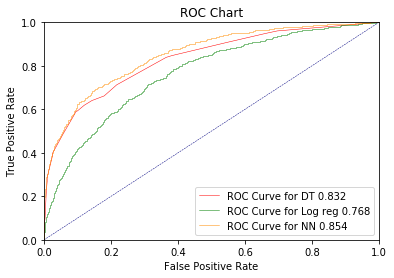

In [43]:
from sklearn.metrics import roc_curve

fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_test, y_pred_proba_dt[:,1])
fpr_log_reg, tpr_log_reg, thresholds_log_reg = roc_curve(y_test, y_pred_proba_log_reg[:,1])
fpr_nn, tpr_nn, thresholds_nn = roc_curve(y_test, y_pred_proba_nn[:,1])

plt.plot(fpr_dt, tpr_dt, label='ROC Curve for DT {:.3f}'.format(roc_index_dt), 
         color='red', lw=0.5)
plt.plot(fpr_log_reg, tpr_log_reg, 
         label='ROC Curve for Log reg {:.3f}'.format(roc_index_log_reg), 
         color='green', lw=0.5)
plt.plot(fpr_nn, tpr_nn, label='ROC Curve for NN {:.3f}'.format(roc_index_nn), 
         color='darkorange', lw=0.5)

# plt.plot(fpr[2], tpr[2], color='darkorange',
#          lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=0.5, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Chart')
plt.legend(loc="lower right")
plt.show()

From looking at the accuracies, the order of models seems to be best neural network > best decision tree > best logistic regression. For the accuracies, the NN is only slightly better than the decision tree, but both were significantly better than the logistic regression. However, when it comes to the AUC, the difference between the models becomes more pronounced with the NN having a much better AUC than the decision tree and the logistic regression having a terrible AUC. From the ROC chart, it seems that the neural network is always as good or better than all of the other models. As the AUC of the logistic regression is so much worse than its accuracy, it seems that the logistic regression is severely overpredicting the majority class. For the decision tree, the AUC is 0.02 worse than the accuracy so it is also overpredicting the majority class a decent amount but nowhere near as much as the logistic regression. It seems that the neural network found the best representation of the data as the AUC is only 0.004 worse than it's accuracy, so it is adequately predicting both the majority and minority classes.

### 5.1.b Which model would you use in deployment based on these findings? Discuss why?
From the problem statement in the task; "Results inferred by these models should inform decision-makers of the (characteristics of) customers who have a high risk of churn. This information can be utilized in multiple ways to assist various stakeholders.". For the purposes of understanding the characteristics of customers who have a high risk of churn, the neural network isn't very useful. This is because the neural network is a very hard model to interpret when compared to logistic regression or decision tree models. For this purpose, the best model would be the decision tree because the performance was only slightly worse than the neural network but it is still easy to understand what is happening in the decision tree by looking at the tree.

However, if the firm wants to use the model to make predictions about new customers, maybe something covered under "This information can be utilized in multiple ways to assist various stakeholders.", then the neural network would be the best model to choose for this purpose because of it's strong performance.

## 5.2 Can you summarise the positives and negative aspects of each predictive modelling method based on this data analysis exercise?
The neural network has the strongest predictive performance but is the least interpretable and takes the longest to train if you want good performance because of the number of parameters to tune. The default settings for this model seem to overfit so parameter tuning is essential for this model type. If you were to have more features than the difference in training time for the neural network versus the other models would become more pronounced.  

The logistic regression has the worst predictive performances of all the models but is the quickest to train and very easy to interpret. There is only one parameter to tune so parameter searching is very quick for this model. Further, the default settings of this model type perform quite well and don't seem to overfit to the data as much as the other model types default settings. It also provides feature importances that we can use for RFE.  

The decision tree is a middle ground between the other options. It is quicker to train than the neural network but is slower than the logistic regression. The default settings for this model also seem to overfit so parameter tuning is essential but it is still a quicker process than the neural network. The model provides feature importances so it can be used for RFE. The model is also very interpretable just like the logistic regression.

## 5.3 Finally, can you build an ensemble model combining all models? Does it produce better/equal/worse performance and why?

In [47]:
# import the model
from sklearn.ensemble import VotingClassifier

# initialise the classifier with 3 different estimators
voting = VotingClassifier(estimators=
                          [('dt', best_tree), ('lr', best_lr), 
                           ('nn', best_nn)], voting='soft')

# fit the voting classifier to training data
voting.fit(X_train, y_train)

# evaluate train and test accuracy
print("Ensemble train accuracy:", voting.score(X_train, y_train))
print("Ensemble test accuracy:", voting.score(X_test, y_test))

# evaluate ROC auc score
y_pred_proba_ensemble = voting.predict_proba(X_test)
roc_index_ensemble = roc_auc_score(y_test, y_pred_proba_ensemble[:, 1])
print("ROC score of voting classifier:", roc_index_ensemble)

Ensemble train accuracy: 0.8563638972592912
Ensemble test accuracy: 0.857429718875502
ROC score of voting classifier: 0.8502095856533392


The best model had an accuracy of 0.8574 and an AUC of 0.8539. The ensembled model had an accuracy of 0.8574 and an AUC of 0.8502. The ensembled model had pretty much the same accuracy as the best model but the AUC score was noticably lower. Overall, this model performed worse than the best individual model did. The accuracy hardly changed, so it could be that the models were all correctly predicting similar values. But the AUC dropped from the best model. This could be because the other models were overpredicting the majority class to some extent, so bringing in the predictions from these models into the predictions from the best model was just dragging down the predictions of the best model. 